# Векторный поиск в задаче матчинга

Воркшоп Samokat.tech и Яндекс.Практикума 17.05-24.05.2023

Векторный поиск - одна из составляющих задачи матчинга, в которой для каждого нового продукта нужно наиболее точно найти N максимально похожих товаров из имеющейся базы. </br>
</br>
В данном воркшопе решалась задача сопоставления уже готовых векторов и максимизации метрики recall@10. </br>
Работа проходила в виде соревнования на платформе Kaggle с поддержкой специалистов из Яндекс.Практикума и Samokat.tech.</br>
[ссылка на соревнование](https://www.kaggle.com/competitions/samokattechworkshop/overview)

**Про матчинг**</br>
Конечная цель матчинга заключается в определении, являются ли два или более предмета эквивалентными или одним и тем же объектом.</br>
В контексте задачи матчинга в базе данных (base) хранится информация о продуктах, которые могут быть предложены для покупки. </br>
Запрос (query) представляет из себя набор конкретных продуктов, для которых необходимо найти соответствие в базе данных.</br>

Задача состоит в том, чтобы автоматически сопоставить запрос с подходящим элементом из базы данных и предоставить пользователю наиболее релевантный результат. Это позволяет снизить дублирование товаров и упростить процесс управления продуктами, что способствует увеличению эффективности и экономии времени.

**РЕШЕНИЕ**

Для векторного поиска использовалась библиотека faiss.</br>
Поиск решения велся с помощью faiss.index_factory с параметрами 'IVF1000, Flat' и nprobe=10, для финализации решения использовался faiss.IndexFlatL2. Предварительно проводилась стандартизация и отбор признаков.</br>
</br>
**Наибольшее улучшение** метрики дала стандартизация данных с помощью StandartScaler, а также исключение 6ти признаков из 72х.
Дополнительный прирост дала нормализация векторов по строкам и введение масшабирующих коэффициентов еще для двух признаков.
</br></br>
**Что еще было испробовано, но не дало результата:**</br>
Приведение всех признаков к нормальному распределению с помощью QuantileTransformer</br>
Уменьшение размерности методом PCA</br>
Обработка признаков методом PCA без снижения размерности с параметром whitening=True</br>
Трансформирование колонки 6 и 71 в базе и трейне, их зануление</br>
Предсказание через FlatIP</br>
Предсказание 50 ближайших соседей через FlatL2 и последующее переранжирование через поиск косинусного сходства (проверялось на 10тыс строк из трейна)</br>

## Загрузка необходимых библиотек

In [2]:
!pip install faiss-cpu --no-cache

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas_profiling as pp

import time
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import normalize

import faiss

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

import scipy.stats as stats
from sklearn.decomposition import PCA


from scipy.spatial.distance import cosine

## Изучение данных

Загрузим и изучим данные

In [2]:
#откроем файлы с данными

try:
    data_base = pd.read_csv('datasets/workshop/base.csv')
except FileNotFoundError:
    data_base = pd.read_csv('/kaggle/input/samokattechworkshop/base.csv')


In [3]:
try:
    data_train = pd.read_csv('datasets/workshop/train.csv')
except FileNotFoundError:
    data_train = pd.read_csv('/kaggle/input/samokattechworkshop/train.csv')

### Общие свойства

In [4]:
print('Размер датасета', data_base.shape)
display(data_base.head(), data_base.info())

Размер датасета (2918139, 73)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2918139 entries, 0 to 2918138
Data columns (total 73 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Id      object 
 1   0       float64
 2   1       float64
 3   2       float64
 4   3       float64
 5   4       float64
 6   5       float64
 7   6       float64
 8   7       float64
 9   8       float64
 10  9       float64
 11  10      float64
 12  11      float64
 13  12      float64
 14  13      float64
 15  14      float64
 16  15      float64
 17  16      float64
 18  17      float64
 19  18      float64
 20  19      float64
 21  20      float64
 22  21      float64
 23  22      float64
 24  23      float64
 25  24      float64
 26  25      float64
 27  26      float64
 28  27      float64
 29  28      float64
 30  29      float64
 31  30      float64
 32  31      float64
 33  32      float64
 34  33      float64
 35  34      float64
 36  35      float64
 37  36      float64
 38  37      floa

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1,1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2,2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3,3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4,4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


None

In [5]:
print('Размер датасета', data_train.shape)
display(data_train.head(), data_train.info())

Размер датасета (100000, 74)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 74 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      100000 non-null  object 
 1   0       100000 non-null  float64
 2   1       100000 non-null  float64
 3   2       100000 non-null  float64
 4   3       100000 non-null  float64
 5   4       100000 non-null  float64
 6   5       100000 non-null  float64
 7   6       100000 non-null  float64
 8   7       100000 non-null  float64
 9   8       100000 non-null  float64
 10  9       100000 non-null  float64
 11  10      100000 non-null  float64
 12  11      100000 non-null  float64
 13  12      100000 non-null  float64
 14  13      100000 non-null  float64
 15  14      100000 non-null  float64
 16  15      100000 non-null  float64
 17  16      100000 non-null  float64
 18  17      100000 non-null  float64
 19  18      100000 non-null  float64
 20  19      100000 non-n

,Id,0,1,2,3,4,5,6,7,8,...,63,64,65,66,67,68,69,70,71,Target
0,0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1,1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2,2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3,3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4,4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


None

В базе товаров - почти 3 млн. строк, 72 колонки признаков типа float64 и одна колонка с уникальным Id товара. В связи с размером датасета метод .info() не показывает количество нулевых значений.</br>
В тренировочной базе - 100 тыс. векторов без пропущенных значений, колонка с уникальным Id и таргет с Id наиболее близкого товара из базы.</br>
</br>
Для каждого товара из тренировочной (а потом из тестовой) выборки необходимо предсказать топ-10 наиболее похожих товаров из базы так, чтобы туда вошел товар-таргет.

Проверка на дубликаты

In [6]:
data_base.duplicated().sum()

0

### Визуализация

Для обзора имеющися данных используем библиотеку Pandas Profiling в режиме minimal=True (т.к. датасет очень большой).

In [7]:
#pp.ProfileReport(data_base, minimal=True)

Результат работы PP выводится в виде интерактивного окна со сводкой и гистограммой по каждой колонке. В GitHub это окно не переносится. </br>
Что видим по свойствам векторов: </br>
Пропущенных и нулевых значений нет.
Все "признаки" (за исключением колонок '6', '21', '25', '33', '44', '59', '65', '70'), имеют куполообразное распределение, т.е. как минимум по форме близки к нормальному распределению. Однако средние не центрированы и все распределения имеют разный масштаб.

Выведем несколько графиков.

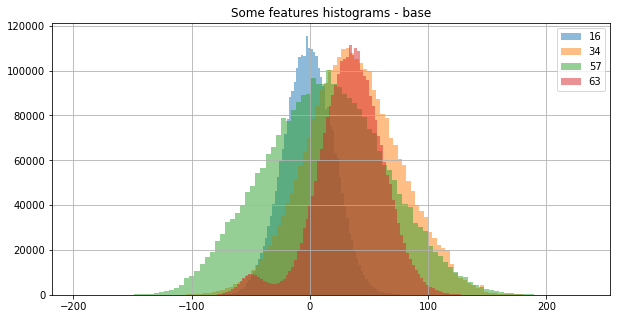

In [8]:
plt.figure(figsize=(10, 5))
data_base.iloc[:, 17].hist(bins=100, alpha=0.5, legend=True);
data_base.iloc[:, 35].hist(bins=100, alpha=0.5, legend=True);
data_base.iloc[:, 58].hist(bins=100, alpha=0.5, legend=True);
data_base.iloc[:, 64].hist(bins=100, alpha=0.5, legend=True);
plt.title('Some features histograms - base', fontsize=12)
plt.show()

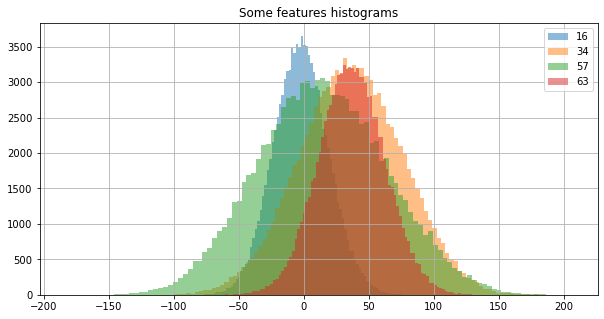

In [9]:
plt.figure(figsize=(10, 5))
data_train.iloc[:, 17].hist(bins=100, alpha=0.5, legend=True);
data_train.iloc[:, 35].hist(bins=100, alpha=0.5, legend=True);
data_train.iloc[:, 58].hist(bins=100, alpha=0.5, legend=True);
data_train.iloc[:, 64].hist(bins=100, alpha=0.5, legend=True);
plt.title('Some features histograms', fontsize=12)
plt.show()

Видим, что распределения более-менее похожи, хотя и отличаются. Например в базе у признака 63 есть два "пика", т.е. в базе существует группа товаров в каким-то дополнительным свойством. Однако в трейне этого свойства нет. 

Выведем также гистограммы некоторых признаков с не-нормальными распределениями.

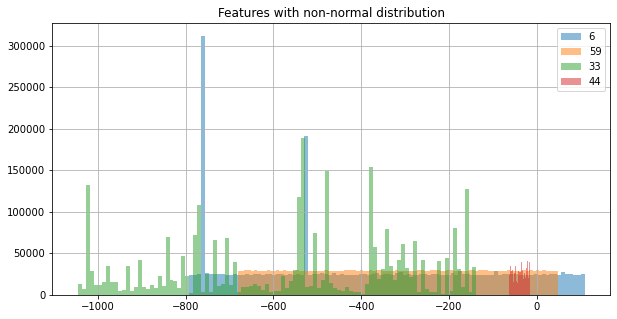

In [10]:
plt.figure(figsize=(10, 5))
data_base.iloc[:, 7].hist(bins=100, alpha=0.5, legend=True);
data_base.iloc[:, 60].hist(bins=100, alpha=0.5, legend=True);
data_base.iloc[:, 34].hist(bins=100, alpha=0.5, legend=True);
data_base.iloc[:, 45].hist(bins=100, alpha=0.5, legend=True);
plt.title('Features with non-normal distribution', fontsize=12)
plt.show()

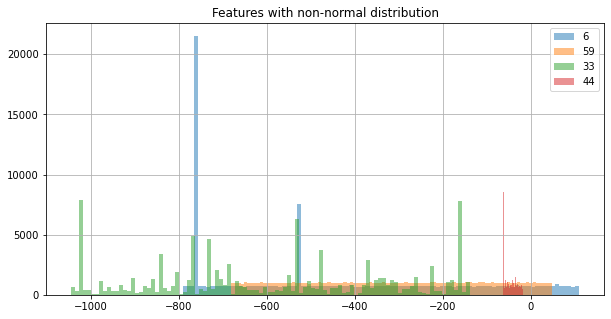

In [11]:
plt.figure(figsize=(10, 5))
data_train.iloc[:, 7].hist(bins=100, alpha=0.5, legend=True);
data_train.iloc[:, 60].hist(bins=100, alpha=0.5, legend=True);
data_train.iloc[:, 34].hist(bins=100, alpha=0.5, legend=True);
data_train.iloc[:, 45].hist(bins=100, alpha=0.5, legend=True);
plt.title('Features with non-normal distribution', fontsize=12)
plt.show()

Видимо, что описываемые этими признаками свойства характерны для большого числа товаров и могут создавать перекосы. Для признака 44 - не самая оптимальная для векторного поиска ситуация, когда в трейне есть пик, а в базе этого нет. 

Попробуем также проверить взаимную корреляцию признаков. Для этого выберем из базы семпл в 100 тыс. строк и построим heatmap

In [12]:
data_base_sample = data_base.sample(n=100000)

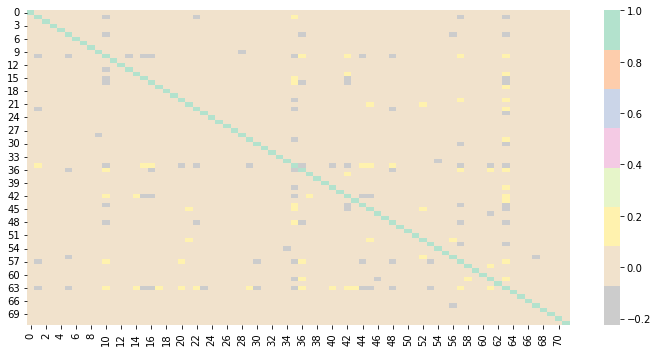

In [13]:
fig = plt.figure(figsize=(10, 5))
sns.heatmap(data_base_sample.corr(), cmap='Pastel2_r')
fig.tight_layout()
plt.show()

Не то, чтобы карта признаков выглядит очень разборчиво, но позволяет сделать вывод об отсутствии заметных корреляций между отдельными признаками.

## Разделим тренировочную выборку и таргет

In [14]:
data_train_train = data_train.drop(columns='Target')
target = data_train['Target']

In [15]:
data_train = None

## Стандартизация данных

Приведём данные к одинаковому масштабу с помощью Standart Scaler

In [16]:
standart_scaler = StandardScaler()

In [17]:
standart_scaler.fit(data_base.iloc[:, 1:])

StandardScaler()

In [18]:
norm_values = pd.DataFrame(standart_scaler.transform(data_base.iloc[:, 1:]))

In [19]:
data_base_norm = pd.concat((data_base['Id'], norm_values), axis=1)

То же самое для тренировочной выборки

In [20]:
train_norm_values = pd.DataFrame(standart_scaler.transform(data_train_train.iloc[:, 1:]))

In [21]:
data_train_norm = pd.concat((data_train_train['Id'], train_norm_values), axis=1)

In [22]:
norm_values = None
train_norm_values = None

Убедимся, что размерность поменялась

In [23]:
display(data_base_norm.head(2))
display(data_train_norm.head(2))

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,0-base,-1.159216,0.620350,-0.513723,1.398558,2.269043,-1.160385,-0.282884,0.373663,-0.435627,...,1.189049,0.190524,0.073589,-0.894789,-2.262493,-0.510438,0.293004,-0.014051,1.781420,-0.312329
1,1-base,2.075715,1.060423,-0.652491,-1.002705,-1.157244,-0.500495,1.130652,-0.871900,-0.623903,...,-1.272135,0.270119,-0.073569,-1.097493,0.225102,0.014491,1.711283,0.059848,1.853726,-0.281052


,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,0-query,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,-2.296794,...,-0.866975,1.274319,-0.024410,-1.173481,-1.035388,0.197184,-0.200786,0.906575,0.995267,0.522963
1,1-query,-0.062146,-0.257159,0.324249,-1.543245,0.204684,-0.419328,1.095696,-1.538329,0.193777,...,1.254600,-0.991073,0.075152,-0.159574,0.207972,0.028031,0.244774,0.709459,-0.611690,-0.083491


Также нормализуем каждый вектор с помощью метода normalize (в целом, эта операция дала несущественный прирост метрики и не является определяющей)

In [24]:
data_base_double_norm_vector = normalize(data_base_norm.iloc[:, 1:])

In [25]:
data_train_double_norm_vector = normalize(data_train_norm.iloc[:, 1:])

## FAISS

Для поиска ближайших векторов используем специальную библиотеку FAISS, которая позволяет осуществлять векторый поиск в многомиллионных объемах данных. Для работы с библиотекой нужно определить индекс - т.е. метод, которым faiss будет осуществлять поиск, загрузить в него базу и запустить процедуру поиска.

### Faiss index factory

Создадим объект index_factory с параметрами IVF1000, Flat: он определит в базе 1000 кластеров и будет осуществлять поиск сначала по центрам кластеров, а потом, когда будет найден наиболее подходящий, по всем его объектам.

In [26]:
dim = 72 #число признаков

In [27]:
second_index = faiss.index_factory(dim, 'IVF1000,Flat') #создаём объект

In [28]:
second_index.train(data_base_double_norm_vector) #обучаем, т.е. разбиваем базу на кластеры

In [29]:
second_index.add(data_base_double_norm_vector) #добавляем вектора

In [30]:
print(second_index.ntotal)

2918139


### Определим вспомогательные функции

В качестве результата поиска faiss возвращает индексы векторов в базе и расстояния. Определим функцию, которая сопоставит индексы и Id найденных объектов.

In [29]:
def take_base_id(indexes):
    indexes_base = []
    for index_line in indexes:
        indexes_base.append(data_base.iloc[index_line, 0].to_list())
    
    return(indexes_base)

А также функцию, которая рассчитает recall@10

In [30]:
def recall_k(target, predict):
    #wrong_indexes = []
    
    in_list = 0
    total_len = len(predict) 
    for i in range(total_len):
        if target[i] in predict[i]:
            in_list +=1
        #else:
            #wrong_indexes.append(data_train_norm.iloc[i, 0])
        
    return in_list/total_len    

### Поиск ближайших соседей

У объекта Faiss index_factory есть параметр nprobe, который определяет число кластеров, по которым будет вестись поиск. Чем больше кластеров, тем точнее результат и медленнее работа алгоритма.</br>

In [33]:
nprobes_variation = {"nprobes": [], "recall": []}

for nprobe in range(1, 21, 2):
    
    second_index.nprobe = nprobe
    _, indexes = second_index.search(data_train_double_norm_vector, 10)
    indexes_base = take_base_id(indexes)
    nprobes_variation['nprobes'].append(nprobe)
    nprobes_variation['recall'].append(recall_k(target, indexes_base))
    
    print(nprobe, recall_k(target, indexes_base))

1 0.53895
3 0.63398
5 0.655
7 0.66485
9 0.67096
11 0.67499
13 0.67754
15 0.67936
17 0.68113
19 0.68264


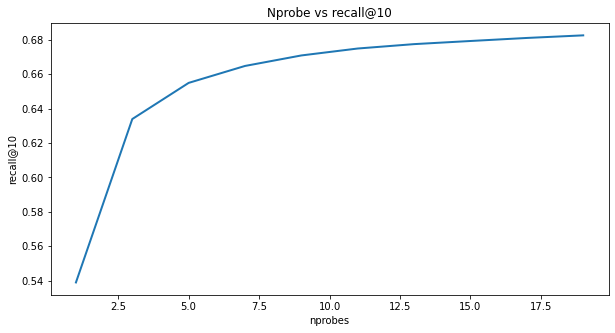

In [34]:
plt.figure(figsize=(10, 5))
plt.title("Nprobe vs recall@10")
plt.plot(nprobes_variation['nprobes'], nprobes_variation['recall'], linewidth=2)
plt.xlabel("nprobes")
plt.ylabel("recall@10")
plt.show()

График начинает выходить на насыщение примерно на nprobe=9-10, поэтому в дальнейших расчетах зафиксируем цифру 10.

## Изучим значимость признаков для правильного ответа

В расчётах используется евклидова метрика (корень из суммы квадратов расстояний по каждой координате).</br>
Чтобы определить, каким образом каждый признак влияет на итоговый результат, обучим классификатор, в который будем подавать 
суммы квадратов для пары query-вектор - предсказанный base-вектор </br>. Target = 1, если пара совпала и 0, если нет.</br>

In [35]:
indexes_df_sample = pd.DataFrame(indexes).reset_index()

In [36]:
my_vectors = []
my_targets = []

Создаем признаки: по 10 предсказаний для каждого query вектора, т.е. 1млн строк.

In [37]:
for i in tqdm(range(len(indexes_df_sample))):
    take_target_vector = data_train_double_norm_vector[indexes_df_sample.iloc[i, 0]]
    take_top10 = indexes_df_sample.iloc[i, 1:]
    for base_number in take_top10:
        take_base_vector = data_base_double_norm_vector[base_number]
        take_base_ids = data_base_norm.iloc[base_number, 0]
        vector_diff = (take_target_vector - take_base_vector)**2
        take_target_value = target[indexes_df_sample.iloc[i, 0]]
        #take_top10_list = indexes_base[indexes_df_sample.iloc[i, 0]]
        my_vectors.append(vector_diff)
        #print(take_target_value, take_base_id)
        if take_target_value == take_base_ids:
            my_targets.append(1)
        else:
            my_targets.append(0)

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [01:33<00:00, 1065.08it/s]


Число правильных ответов в нашем датасете:

In [38]:
sum(my_targets)/len(my_targets)*1000000

68264.0

In [39]:
lr = LogisticRegression()

In [40]:
lr.fit(my_vectors, my_targets)

C:\Users\trety\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [41]:
weights = lr.coef_.T

In [36]:
def features_importances_plot(weights):
    feature_importans = pd.Series(weights).sort_values(ascending=False)

    plt.figure(figsize=(16, 7))
    sns.set(style="whitegrid")
    sns.barplot(x=feature_importans.index, y=feature_importans);
    plt.title('Значимость признаков', fontsize=12)
    plt.xticks(rotation = 55)
    plt.show()

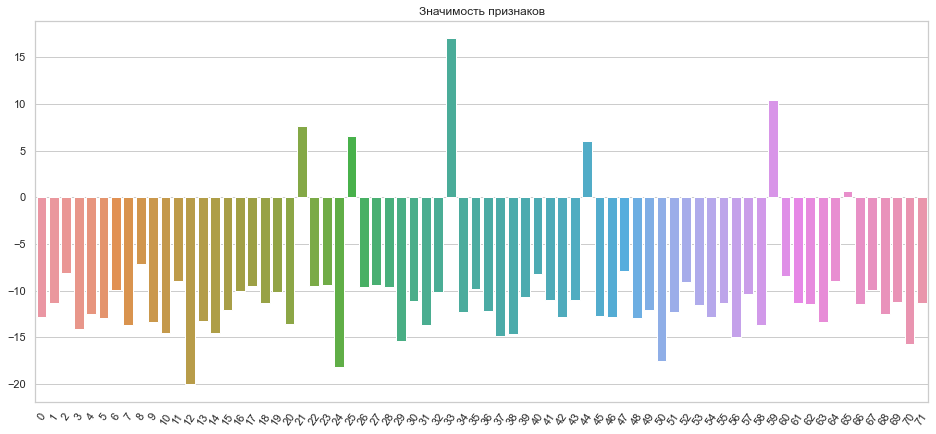

In [43]:
features_importances_plot(weights[:, 0])

Видим, что из 8ми не-нормально распределенных признаков 6 имеют вклад, обратный по знаку всем остальным. Попробуем удалить их и посмотреть на результат.

## Векторный поиск на сокращенном датасете

Удалим колонки '21', '25', '33', '44', '59', '65' из датасета и повторно нормализуем.

In [24]:
data_base_norm = data_base_norm.drop(columns = [21, 25, 33, 44, 59, 65])
data_train_norm = data_train_norm.drop(columns = [21, 25, 33, 44, 59, 65])

In [25]:
data_base_double_norm_vector = normalize(data_base_norm.iloc[:, 1:])

In [26]:
data_train_double_norm_vector = normalize(data_train_norm.iloc[:, 1:])

Векторный поиск с nprobe= 10

In [27]:
dim=66
second_index = faiss.index_factory(dim, 'IVF1000,Flat') #создаём объект
second_index.train(data_base_double_norm_vector) #обучаем, т.е. разбиваем базу на кластеры
second_index.add(data_base_double_norm_vector) #добавляем вектора

In [31]:
second_index.nprobe = 10

_, indexes = second_index.search(data_train_double_norm_vector, 10)
indexes_base = take_base_id(indexes)

recall_k(target, indexes_base)

0.72785

Максимальный результат на полном датасете в предыдущей итерации получился 0.68264.</br>
Посмотрим на значимость признаков еще раз:

In [32]:
indexes_df_sample = pd.DataFrame(indexes).reset_index()

In [33]:
my_vectors = []
my_targets = []

In [34]:
for i in tqdm(range(len(indexes_df_sample))):
    take_target_vector = data_train_double_norm_vector[indexes_df_sample.iloc[i, 0]]
    take_top10 = indexes_df_sample.iloc[i, 1:]
    for base_number in take_top10:
        take_base_vector = data_base_double_norm_vector[base_number]
        take_base_ids = data_base_norm.iloc[base_number, 0]
        vector_diff = (take_target_vector - take_base_vector)**2
        take_target_value = target[indexes_df_sample.iloc[i, 0]]
        #take_top10_list = indexes_base[indexes_df_sample.iloc[i, 0]]
        my_vectors.append(vector_diff)
        #print(take_target_value, take_base_id)
        if take_target_value == take_base_ids:
            my_targets.append(1)
        else:
            my_targets.append(0)

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [01:30<00:00, 1107.30it/s]


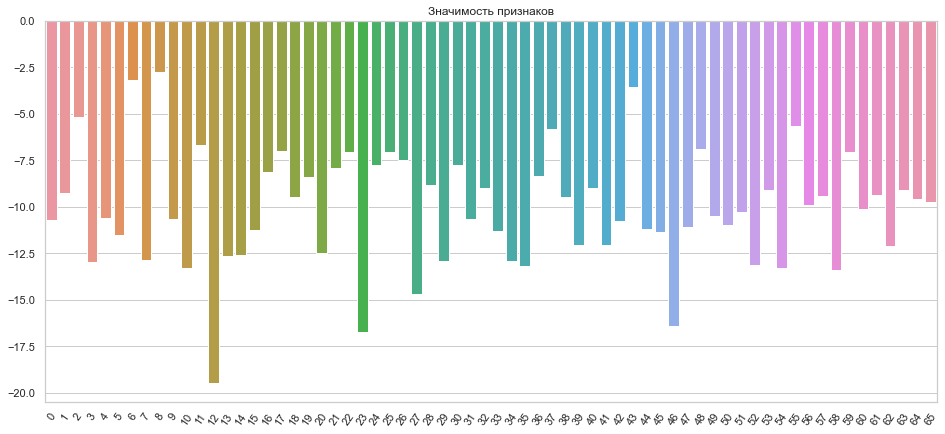

In [37]:
lr = LogisticRegression()
lr.fit(my_vectors, my_targets)

weights = lr.coef_.T
features_importances_plot(weights[:, 0])

В целом карта значимости признаков, полученая на лог регрессии довольно ровная. Попробуем получить карту признаков с помощью градентного бустинга.

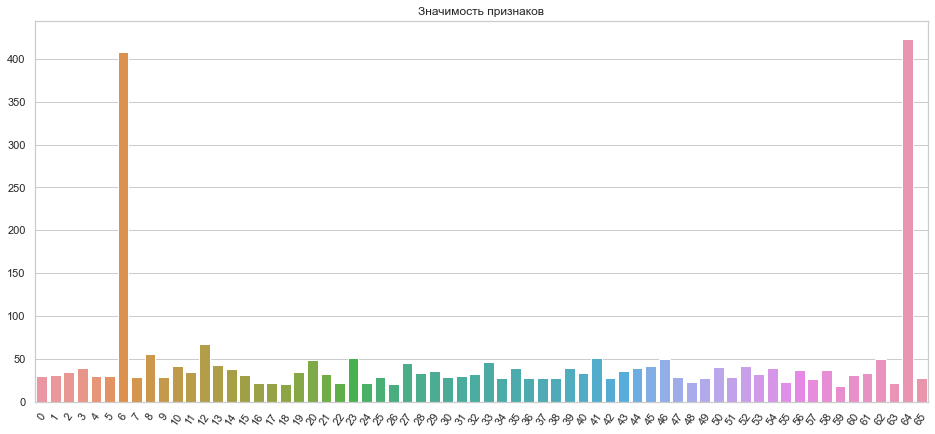

In [38]:
lgbm = LGBMClassifier()
lgbm.fit(my_vectors, my_targets)

weights = lgbm.feature_importances_.T
features_importances_plot(weights)

А вот кэтбуст дает другой результат - наибольшую значимость имеют два оставшихся в датасете признака с не-нормальным распределением.

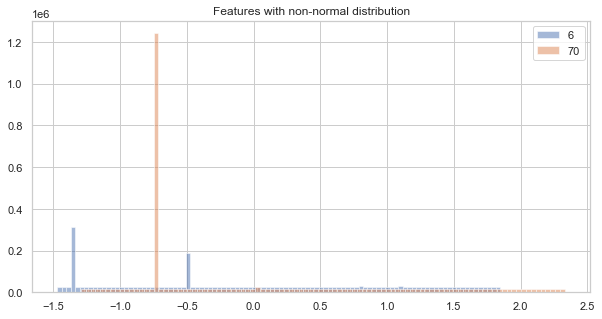

In [51]:
plt.figure(figsize=(10, 5))
data_base_norm.iloc[:, 7].hist(bins=100, alpha=0.5, legend=True);
data_base_norm.iloc[:, 65].hist(bins=100, alpha=0.5, legend=True);
plt.title('Features with non-normal distribution', fontsize=12)
plt.show()

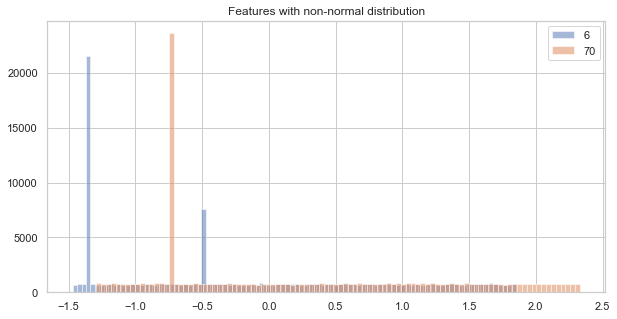

In [43]:
plt.figure(figsize=(10, 5))
data_train_norm.iloc[:, 7].hist(bins=100, alpha=0.5, legend=True);
data_train_norm.iloc[:, 65].hist(bins=100, alpha=0.5, legend=True);
plt.title('Features with non-normal distribution', fontsize=12)
plt.show()

В процессе изучения этих признаков и из влияния на результаты оказалось, что:
- в правильно заматченных векторах трейна доля пиковых значений из столбца 6 выше, чем в среднем по датасету, а в неправильно определенных - наоборот ниже
- для колонки 71 наоборот - в неправильно заматченных query-векторах доля пиковых значений выше, чем в тех, для которых матчи были найдены верно.

Была предпринята попытка преобразовать колонки в трейн-датасете, занулить их, привести к нормальному распределению, но это не дало результата. В итоге был введен эмпирически полученный масштабирующий коэффициент 0,8.

In [52]:
weights_norm = np.ones(66)

In [53]:
weights_norm[6] = 0.8
weights_norm[64] = 0.8

In [54]:
data_base_double_norm_vector_w = data_base_double_norm_vector*weights_norm
data_train_double_norm_vector_w = data_train_double_norm_vector*weights_norm

Сделаем векторный поиск еще раз:

In [57]:
dim=66
second_index = faiss.index_factory(dim, 'IVF1000,Flat') #создаём объект
second_index.train(data_base_double_norm_vector_w) #обучаем, т.е. разбиваем базу на кластеры
second_index.add(data_base_double_norm_vector_w) #добавляем вектора

In [58]:
second_index.nprobe = 10

_, indexes = second_index.search(data_train_double_norm_vector_w, 10)
indexes_base = take_base_id(indexes)

recall_k(target, indexes_base)

0.72809

Прирост по сравнению с последней метрикой 0.72785 небольшой, но есть. </br>
К сожалению, не зная истинной природы признаков 6 и 71, довольно сложно делать вывод о том, насколько устойчивым будет полученное решение. В реальной задаче, вероятно, скор можно было бы улучшить, совершенствуя методику обработки этих признаков при получении векторов query.

## FAISS - 2

Прогоним преобразованные данные через полный перебор FlatL2.

In [59]:
my_index = faiss.IndexFlatL2(dim)

In [60]:
my_index.add(data_base_double_norm_vector_w)

In [61]:
print(my_index.ntotal)

2918139


In [62]:
_, indexes = my_index.search(data_train_double_norm_vector_w, 10)

In [63]:
indexes_base = take_base_id(indexes)

In [64]:
recall_k(target, indexes_base)

0.74836

Поскольку прямой перебор даёт чуть более точный результат, итоговая метрика на трейне также получилась выше.

## Test predictions

In [68]:
try:
    data_test = pd.read_csv('datasets/workshop/test.csv', index_col=0)
except FileNotFoundError:
    data_test = pd.read_csv('/kaggle/input/samokattechworkshop/test.csv')

In [71]:
data_test_norm = pd.DataFrame(standart_scaler.transform(data_test))

In [72]:
data_test_norm = data_test_norm.drop(columns = [21, 25, 33, 44, 59, 65])

In [73]:
test_double_norm_vector = normalize(data_test_norm)

In [74]:
_, test_indexes = my_index.search(test_double_norm_vector, 10)

In [75]:
test_base_indexes = take_base_id(test_indexes)

In [76]:
data_test['Predicted'] = test_base_indexes
data_test['Predicted'] = data_test['Predicted'].apply(' '.join)

In [77]:
data_test['Predicted'].to_frame().to_csv('faiss_flat2l_scaled_normalized_without_6_columns_weights08.csv')